In [253]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
%matplotlib inline

import importlib
from globals import *
import cell
import tissue
import time

importlib.reload(cell)
importlib.reload(tissue)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'tissue' from '/Users/tomernadiv/Desktop/MSc/Courses/DS Project/vertex_model/tissue.py'>

In [274]:
pickle_path = r'/Users/tomernadiv/Desktop/MSc/Courses/DS Project/vertex_model/results.pkl'
import pickle
with open(pickle_path, 'rb') as f:
    results = pickle.load(f)

In [275]:
energies = results['energy']
areas = results['area']
# remove keys 6,7 from dict
for i in range(6, 8):
    del energies[i]
    del areas[i]

<Figure size 1000x600 with 0 Axes>

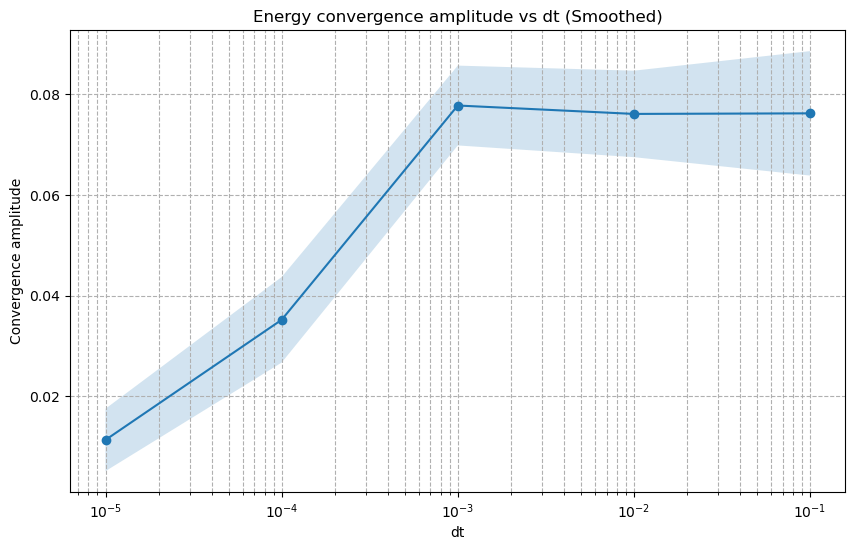

In [272]:
import numpy as np
from scipy.signal import find_peaks

def get_peak_amplitudes(energy, min_prominence=1e-6, smooth=True, window=10):
    # Find local maxima and minima
    peaks, _ = find_peaks(energy, prominence=min_prominence)
    troughs, _ = find_peaks(-np.array(energy), prominence=min_prominence)
    
    # Extract peak and trough values
    peak_vals = energy[peaks]
    trough_vals = energy[troughs]
    
    # Match lengths
    min_len = min(len(peak_vals), len(trough_vals))
    amps = peak_vals[:min_len] - trough_vals[:min_len]
    
    if smooth and len(amps) >= window:
        # Apply simple moving average
        amps = np.convolve(amps, np.ones(window)/window, mode='valid')
    
    return amps

dt_values = []
convergence_amps = []
convergence_amps_std = []
amps_dict = {}
num_convergence_peaks = 200

for dt, energy in energies.items():
    dt_values.append(10**-dt)
    amps = get_peak_amplitudes(np.array(energy), smooth=True, window=50)
    amps_dict[dt] = amps
    if len(amps) >= num_convergence_peaks:
        convergence_amps.append(np.mean(amps[:-num_convergence_peaks]))
        convergence_amps_std.append(np.std(amps[:-num_convergence_peaks]))
    else:
        convergence_amps.append(np.mean(amps))
        convergence_amps_std.append(np.std(amps))


plt.figure()
plt.plot(dt_values, convergence_amps, marker='o', label='Convergence amplitude')
plt.fill_between(dt_values,
                 np.array(convergence_amps) - np.array(convergence_amps_std),
                 np.array(convergence_amps) + np.array(convergence_amps_std),
                 alpha=0.2, label='Standard deviation')
plt.xscale('log')
plt.xlabel('dt')
plt.ylabel('Convergence amplitude')
plt.title('Energy convergence amplitude vs dt (Smoothed)')
plt.grid(True, which="both", ls='--')
plt.savefig('results/plots/convergence_amplitude_vs_dt.png', dpi=300, bbox_inches='tight')
plt.show()

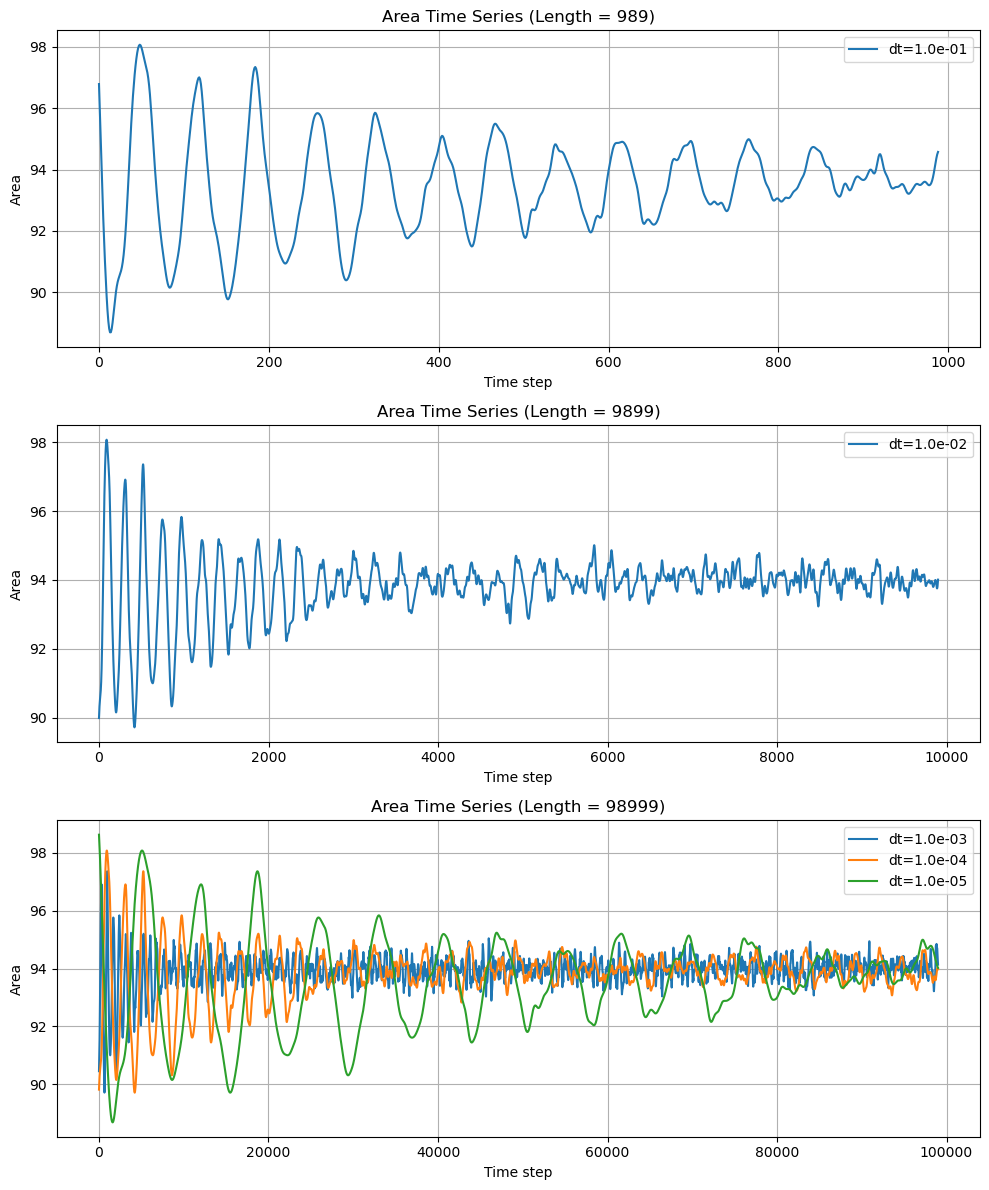

In [310]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Group areas by length
length_groups = defaultdict(list)
for dt, area in areas.items():
    length_groups[len(area)].append((dt, area))

# Plot each group in a separate subplot
n_groups = len(length_groups)
fig, axes = plt.subplots(n_groups, 1, figsize=(10, 4 * n_groups), sharex=False)

if n_groups == 1:
    axes = [axes]  # Make it iterable

for ax, (length, dt_area_list) in zip(axes, length_groups.items()):
    for dt, area in dt_area_list:
        ax.plot(area, label=f'dt={10**-dt:.1e}')
    ax.set_title(f'Area Time Series (Length = {length})')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Area')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig('results/plots/area_time_series.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
T = tissue.Tissue(cell_radius=cell_radius, num_cols=6, num_rows=6)

time_limit = 20
total_energy = []
for t in range(1, time_limit):

    # plotting
    # fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 10))
    # ax1.set_title(f"Timestamp: {t}")
    # T.plot_tissue(ax=ax1)
    # T.plot_heights_distribution(ax=ax2, bins=30)
    # plt.tight_layout()
    # plt.show()
    # clear_output(wait=True)
    # time.sleep(0.5)


    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plt.title(f"Timestamp: {t}")
    T.plot_tissue(ax=ax)
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)
    time.sleep(0.5)

    # computation
    T.compute_all_forces(['spring', 'line_tension'])
    T.update_positions(dt=0.01)
    T.update_heights()
    total_energy.append(T.compute_total_energy())

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Timestamp: {time_limit}")
T.plot_tissue(ax=ax)
plt.show()

plt.plot(total_energy)
plt.xlabel("Time step")
plt.ylabel("Total Energy" )
plt.title("Total Energy Over Time")
plt.grid(True)
plt.show()

KeyboardInterrupt: 